# Servo simulation draft

Outline for simulating response from two-level ion when driven with a drifting clock laser. Linewidth functions interchangeable.

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import peak_widths, find_peaks

Lineshape function used is the ideal Rabi flopping when driven with pi pulses:
\begin{align}
\rho_{ee}(t) &= \left( \frac{\pi}{2} \right)^2 \textrm{sinc}^2 \left( \frac{\sqrt{\pi^2 + \delta^2 t^2}}{2} \right)
\end{align} 

In [131]:
def lineshape(delta, t):
    sinc_arg = 0.5 * np.sqrt(np.pi ** 2 + np.square(delta) * np.square(t))
    out = (np.pi/2.)**2 * np.square(np.divide(np.sin(sinc_arg), sinc_arg))
    return out

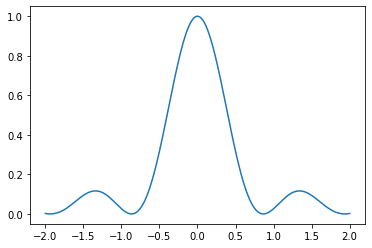

In [216]:
d, step = np.linspace(-2, 2, 1000, retstep=True)
plt.plot(d, lineshape(d, 2*np.pi))

The slope ($k_p(\delta, t)$) is calculated using a simple finite differential scheme from the lineshape. More sophisticated methods could also be used.

In [188]:
def slope(lineshape_func, delta, t, dlims=(-2, 2), acc=1000):
    assert(delta > dlims[0] and delta < dlims[1]), "Derivative not defined outside range!"
    ds, step = np.linspace(dlims[0], dlims[1], acc, retstep=True)
    lineshape = lineshape_func(ds, t)
    d_ls = np.diff(lineshape) / step
    nearest = np.argmin(np.abs(ds-delta))
    return d_ls[nearest]

Visualising the result of laser offset on the measured probabilities $p_R$ and $p_B$. Scipy ``peak_widths`` used here to calculate FWHM.

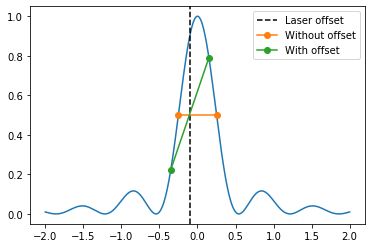

In [158]:
l_s = lineshape(d,10)
widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5)
without_offset = get_both_ps(d, lineshape, 10)
laser_offset = -0.1
with_offset = get_both_ps(d, lineshape, 10, laser_offset=laser_offset)
plt.plot(d, l_s)
plt.axvline(laser_offset, color='k', linestyle='--', label='Laser offset')
plt.plot([without_offset['x_R'], without_offset['x_B']],[without_offset['p_R'], without_offset['p_B']], marker='o', label='Without offset')
plt.plot([with_offset['x_R'], with_offset['x_B']],[with_offset['p_R'], with_offset['p_B']], marker='o', label='With offset')
plt.legend()

Simulating a measurement by first finding the detunings $\delta_R$ and $\delta_B$ corresponding to the probability measurements assuming $\epsilon = 0$ (laser frequency exactly at transition frequency) and then offsetting them by the laser offset (compounded from drift, laser noise etc.). New probabilities are then calculated from the linewidth function.

In [157]:
def get_both_ps(d, lineshape_func, t, laser_offset=None):
    l_s =lineshape_func(d, t)
    widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5)
    x_R = d[int(np.rint(widths[2][0]))]
    x_B = d[int(np.rint(widths[3][0]))]
    p_R = p_B = widths[1][0]
    if laser_offset is not None:
        x_R += laser_offset
        x_B += laser_offset
        p_R = lineshape_func(x_R, t)
        p_B = lineshape_func(x_B, t)
    return {'x_R': x_R,
            'x_B': x_B,
            'p_R': p_R,
            'p_B': p_B}

Correction signal
\begin{equation}
E = G \left( \frac{p_B - p_R}{p_B + p_R} \right)
\end{equation}

In [197]:
def correction_signal(gain, measurement_dict):
    p_R = measurement_dict['p_R']
    p_B = measurement_dict['p_B']
    return gain * (p_R - p_B)/(p_B + p_R)

Allan deviation (from Dubé2015a)
\begin{equation}
\sigma_y(\tau) = -\left( \frac{2 \sqrt{p_X (1 - p_X)}}{k_p \eta_0} \right) \sqrt{\frac{T_c}{\tau}}
\end{equation}

In [219]:
def allan_deviation(p_X, k_p, T_c, tau):
    eta0 = 444.779e12 # Hz, from Ludlow2015a
    out = (-2 * np.sqrt(p_X * (1 - p_X))) / (k_p * eta0) * np.sqrt(T_c / tau)
    return out

Text(0.5, 0, 'Averaging time (t_\\pi)')

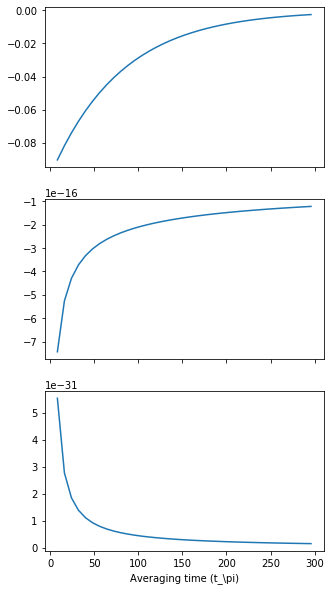

In [255]:
# main simulation loop
T_c = 8 # in tau_pis?
max_tau = 300
t = np.arange(start=T_c,stop=max_tau, step=T_c)
etas = np.zeros(len(t))
sigmas = np.zeros(len(t))
initial_offset = -.1
state_preparation = True
tau_ls = 1 # t for lineshape
d, step = np.linspace(-2, 2, 1000, retstep=True)
without_offset = get_both_ps(d, lineshape, 10)
k_p = slope(lineshape, without_offset['x_R'], 10) # which side of lineshape to use?
p_X = 0.5 if state_preparation else 0.25
g = -2 * p_X / k_p
f = initial_offset
laser_drift_per_timestep = 0
for i in range(0, len(t)):
    tau = t[i]
    measurement = get_both_ps(d, lineshape, tau_ls, f) # do measurement
    f = f + correction_signal(g, measurement) + laser_drift_per_timestep # correct frequency
    etas[i] = f
    sigmas[i] = allan_deviation(p_X, k_p, T_c, tau)

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5, 10))
ax[0].plot(t, etas)
ax[1].plot(t, sigmas)
ax[2].plot(t, np.square(sigmas))
plt.xlabel('Averaging time (t_\pi)')

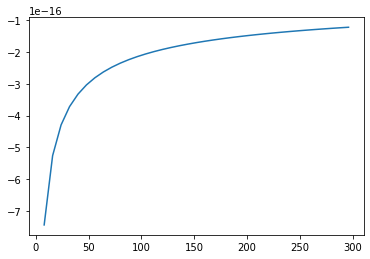

In [250]:
plt.plot(t, sigmas)

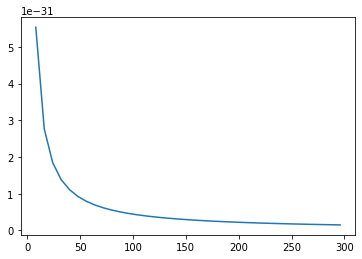

In [251]:
plt.plot(t, np.square(sigmas))